In [157]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import winsound as ws
%matplotlib widget

## Constantes

In [158]:
# ua = 149597870700 # m/ua
# d = 86400 # s/d
# m_sun = 1.9885e30 # kg/m_Sun
# G = 6.67430e-11 # m³/kg/s² 
G = 295.9256211e-6  # G*(86400**2)*m_sun/(ua**3) # ua³/m_Sun/d²
masses = np.array([1., 954.79e-6, 285.87e-6]) # [Sun, Jupiter] in m_Sun


## Méthodes

In [159]:
def Init_Cond_Cart(N,masses,*args):
    """
    === Params ===\n
    N :         Number of Body
    masses :    1D array masses [Sun, Jup, Sat,...]
                
    *args :     2D arrays (3,3) of position and velocity
                First axis : coordinates [x, y, z]
                Second axis : velocities [x, y, z]

    === Return ===\n
    pos_init :  1D array of positions [x_Sun, y_Sun, z_Sun, x_Jup, ...]
    mom_init :  1D array of momentum [x_Sun, y_Sun, z_Sun, x_Jup, ...]
    """
    pos_init = np.zeros(N*3)
    mom_init = np.zeros(N*3)
    
    for i in range(1,N):
        j = i*3
        pos_init[j:j+3] = args[i][0]
        mom_init[j:j+3] = args[i][1]*masses[i]

    # elif center == 'CM':
    #     R = np.zeros(3)
    #     # R = (masses[0]*args[0][0]+masses[1]*args[1][0])/(masses[0]+masses[1])
    #     for i in range(N):
    #         R += masses[i]*args[i][0]/(np.sum(masses[:N]))
    #     for i in range(N):
    #         j = i*3
    #         pos_init[j:j+3] = args[i][0] - R
    #         mom_init[j:j+3] = args[i][1]*masses[i] 
    #         # mom_init[0:3] -= mom_init[j:j+3]
    #     # mom_init[0:3] = -mom_init[3:6]
    return pos_init, mom_init

def distance(x1,x2):
    return np.sqrt(((x1[0]-x2[0])**2)+((x1[1]-x2[1])**2)+((x1[2]-x2[2])**2))

def dpos_dt(pos,mom,masses):
    N = len(masses)
    dpos = np.zeros_like(pos)
    for i in range(N):
        j = i*3
        dpos[j] = mom[j]/masses[i]
        dpos[j+1] = mom[j+1]/masses[i]
        dpos[j+2] = mom[j+2]/masses[i]
    return dpos

def dmom_dt(pos,mom,masses):
    N = len(masses)
    dmom = np.zeros_like(mom)
    for i in range(N):
        j = i*3
        for k in range(N):
            l = k*3
            if i!=k :
                dmom[j] += -G*masses[i]*masses[k]/(distance(pos[j:j+3],pos[l:l+3])**3)*(pos[j]-pos[l])
                dmom[j+1] += -G*masses[i]*masses[k]/(distance(pos[j:j+3],pos[l:l+3])**3)*(pos[j+1]-pos[l+1])
                dmom[j+2] += -G*masses[i]*masses[k]/(distance(pos[j:j+3],pos[l:l+3])**3)*(pos[j+2]-pos[l+2])
    return dmom

def energy(pos,mom,masses):
    N = len(masses)
    kin = 0
    pot = 0
    for i in range(N):
        j = i*3
        kin += 1/2*np.sum(mom[j:j+3]**2)/masses[i]
        for k in range(i+1,N):
            l = k*3
            pot += G*masses[i]*masses[k]/distance(pos[j:j+3],pos[l:l+3])
    return (kin-pot)

def CM(pos,masses):
    N = pos.shape[0]//3
    cm = np.zeros((3,pos.shape[1]))
    for t in range(pos.shape[1]):
        for i in range(N):
            j = i*3
            cm[:,t] += pos[j:j+3,t]*masses[i]
    return cm/np.sum(masses[:N])

def str_to_array(s):
    arr = np.zeros((2,3))
    a = str.split(s,sep='\t')
    arr[0] = a[:3]
    arr[1] = a[3:]
    return arr


In [160]:
def Heun(N, dt, tmax, masses, *args):
    """
    === Params ===\n
    masses :    array of masses [Sun, Jupiter]
    pos_init :  2D array of position
                First axis : coordinates [x_Sun, y_Sun, z_Sun, x_Jup, ...]
                Second axis : timestep            
    mom_init :    2D array of momentum
                First axis : momentum [x_Sun, y_Sun, z_Sun, x_Jup, ...]
                Second axis : timestep
    === Return ===\n
    dict :      't' :   1D array of timestep
                'pos' : 2D array of positions
                        First index : coordinates
                        Second index : timestep
                'mom' : 2D array of momentum
                        First index : coordinate
                        Second index : timestep
                'E' :   1D array of energy through time
    """
    pos_init, mom_init = Init_Cond_Cart(N,masses,*args)
    n_t = int(np.round(tmax/dt))
    dt = tmax/n_t
    t = np.linspace(0,tmax,n_t)
    masses = masses[:N]
    pos = np.zeros((len(pos_init),len(t)))
    mom = np.zeros((len(mom_init),len(t)))
    E = np.zeros(len(t))
    pos[:,0] = pos_init
    mom[:,0] = mom_init
    E[0] = energy(pos[:,0], mom[:,0],masses)
    for i in range(len(t)-1):
        mom_tilde = mom[:,i] + dt*dmom_dt(pos[:,i],mom[:,i],masses)
        pos_tilde = pos[:,i] + dt*dpos_dt(pos[:,i],mom[:,i],masses)

        mom[:,i+1] = mom[:,i] + dt/2*(dmom_dt(pos_tilde,mom_tilde,masses)+dmom_dt(pos[:,i],mom[:,i],masses))
        pos[:,i+1] = pos[:,i] + dt/2*(dpos_dt(pos_tilde,mom_tilde,masses)+dpos_dt(pos[:,i],mom[:,i],masses))
        
        E[i+1] = energy(pos[:,i+1], mom[:,i+1], masses)
    # Rectification de la position par rappot au CM
    cm = CM(pos,masses)
    for i in range(N):
        j = i*3
        pos[j:j+3,:] = pos[j:j+3,:]-cm
    return {'t':t,'pos':pos,'mom':mom,'E':E,'dt':dt}

In [161]:
def SV(N, dt, tmax, masses, *args):
    """
    === Params ===\n
    masses :    array of masses [Sun, Jupiter]
    pos_init :  2D array of position
                First axis : coordinates [x_Sun, y_Sun, z_Sun, x_Jup, ...]
                Second axis : timestep            
    mom_init :    2D array of momentum
                First axis : momentum [x_Sun, y_Sun, z_Sun, x_Jup, ...]
                Second axis : timestep
    === Return ===\n
    dict :      't' :   1D array of timestep
                'pos' : 2D array of positions
                        First index : coordinates
                        Second index : timestep
                'mom' : 2D array of momentum
                        First index : coordinate
                        Second index : timestep
                'E' :   1D array of energy through time
    """
    pos_init, mom_init = Init_Cond_Cart(N,masses,*args)
    n_t = int(np.round(tmax/dt))
    dt = tmax/n_t
    t = np.linspace(0,tmax,n_t)
    masses = masses[:N]
    pos = np.zeros((len(pos_init),len(t)))
    mom = np.zeros((len(mom_init),len(t)))
    E = np.zeros(len(t))
    pos[:,0] = pos_init
    mom[:,0] = mom_init
    E[0] = energy(pos[:,0],mom[:,0],masses)
    for i in range(len(t)-1):
        mmom = mom[:,i] + dt/2*dmom_dt(pos[:,i],mom[:,i],masses)

        pos[:,i+1] = pos[:,i] + dt*dpos_dt(pos[:,i],mmom,masses)
        
        mom[:,i+1] = mmom + dt/2*dmom_dt(pos[:,i+1],mmom,masses)

        E[i+1] = energy(pos[:,i+1],mom[:,i+1],masses)
        
    # Rectification de la position par rappot au CM
    cm = CM(pos,masses)
    for i in range(N):
        j = i*3
        pos[j:j+3,:] = pos[j:j+3,:]-cm
    return {'t':t,'pos':pos,'mom':mom,'E':E,'dt':dt}

## Calculs

In [164]:
# Conditions initiales taken 08-15-2024 at 12:00:00
N_body = 3
Sun = np.array([[0.,0.,0.],[0.,0.,0.]])
Jup = str_to_array('2.6612786825339	4.2508243026341	-0.0771991078745	-0.0064893013125	0.0043637460975	0.0001270618987')
Sat = str_to_array('9.2195874869192\t-2.9920487806866\t-0.3149005362607\t0.0014084238297\t0.0053001590964\t-0.0001482901014')

dt = 60             # nbre de jours par dt
N_tmax =  5000      # nbre d'années de la simu
tmax = N_tmax*365   # jours

solHeun = Heun(N_body, dt, tmax, masses, Sun, Jup, Sat)
solSV = SV(N_body, dt, tmax, masses, Sun, Jup, Sat)

59.9993424729592


## Plot

### Plot Heun

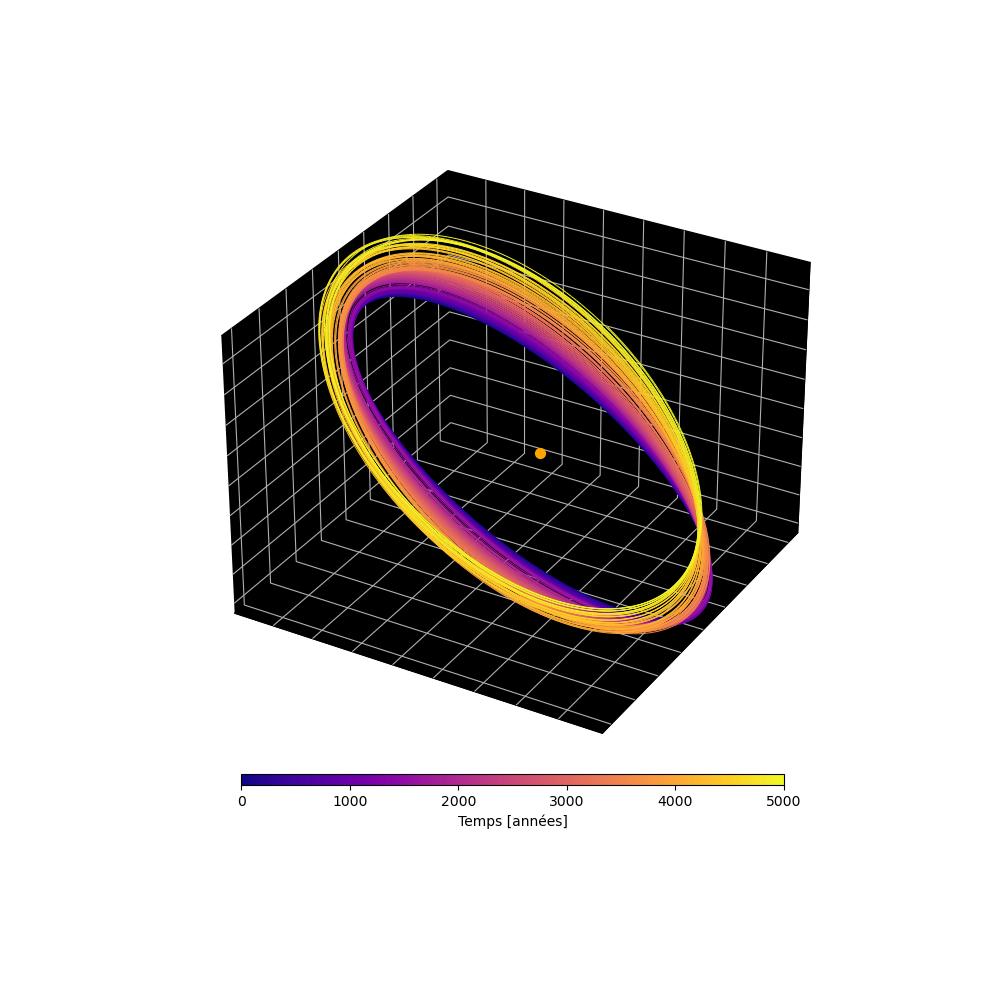

In [165]:
norm = plt.Normalize(solHeun['t'].min(),solHeun['t'].max()) # Etablis la norme pour la colorbar

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1,projection='3d')

# Crée la trajectoire de Jupiter et l'associe à la colorbar
points_J = np.array([solHeun['pos'][3,:],solHeun['pos'][4,:],solHeun['pos'][5,:]]).T.reshape(-1,1,3) 
segments_J = np.concatenate([points_J[:-1], points_J[1:]], axis=1)
lc_J = Line3DCollection(segments=segments_J,cmap = 'plasma',norm = norm)
lc_J.set_array(solHeun['t'])
lc_J.set_linewidth(0.4)
lc_J.set_alpha(.6)
line_J = ax.add_collection(lc_J)

ax.set_xlim(left=solHeun['pos'][3,:].min(),right=solHeun['pos'][3,:].max())
ax.set_ylim(bottom=solHeun['pos'][4,:].min(),top=solHeun['pos'][4,:].max())
ax.set_zlim(bottom=solHeun['pos'][5,:].min(),top=solHeun['pos'][5,:].max())

if N_body == 3:
    # Crée la trajectoire de Saturne et l'associe à la colorbar
    points_S = np.array([solHeun['pos'][6,:],solHeun['pos'][7,:],solHeun['pos'][8,:]]).T.reshape(-1,1,3)
    segments_S = np.concatenate([points_S[:-1], points_S[1:]], axis=1)
    lc_S = Line3DCollection(segments=segments_S,cmap = 'plasma',norm = norm)
    lc_S.set_array(solHeun['t'])
    lc_S.set_linewidth(.7)
    lc_S.set_alpha(.6)
    line_S = ax.add_collection(lc_S)

    ax.set_xlim(left=solHeun['pos'][6,:].min(),right=solHeun['pos'][6,:].max())
    ax.set_ylim(bottom=solHeun['pos'][7,:].min(),top=solHeun['pos'][7,:].max())
    ax.set_zlim(bottom=solHeun['pos'][8,:].min(),top=solHeun['pos'][8,:].max())

color = fig.colorbar(line_S,ax=ax,label='Temps [années]',orientation='horizontal',aspect=50,shrink=.7,pad=0)
color.set_ticks(np.linspace(0,N_tmax*365,6))
color.set_ticklabels(np.linspace(0,N_tmax,6,dtype=int))

ax.plot(solHeun['pos'][0,:],solHeun['pos'][1,:],solHeun['pos'][2,:],c='orange')
ax.scatter(solHeun['pos'][0,0],solHeun['pos'][1,0],solHeun['pos'][2,0],c='orange',s=50)

x=1
ax.xaxis.set_pane_color((x,x,x,1))
ax.yaxis.set_pane_color((x,x,x,1))
ax.zaxis.set_pane_color((x,x,x,1))
ax.grid(color=(1-x,1-x,1-x,1))
xticks =  ax.xaxis.get_major_ticks()
for t in xticks:
    t.set_visible(False)
    t.set_visible(False)
yticks =  ax.yaxis.get_major_ticks()
for t in yticks:
    t.set_visible(False)
    t.set_visible(False)
zticks =  ax.zaxis.get_major_ticks()
for t in zticks:
    t.set_visible(False)
    t.set_visible(False)

plt.show()

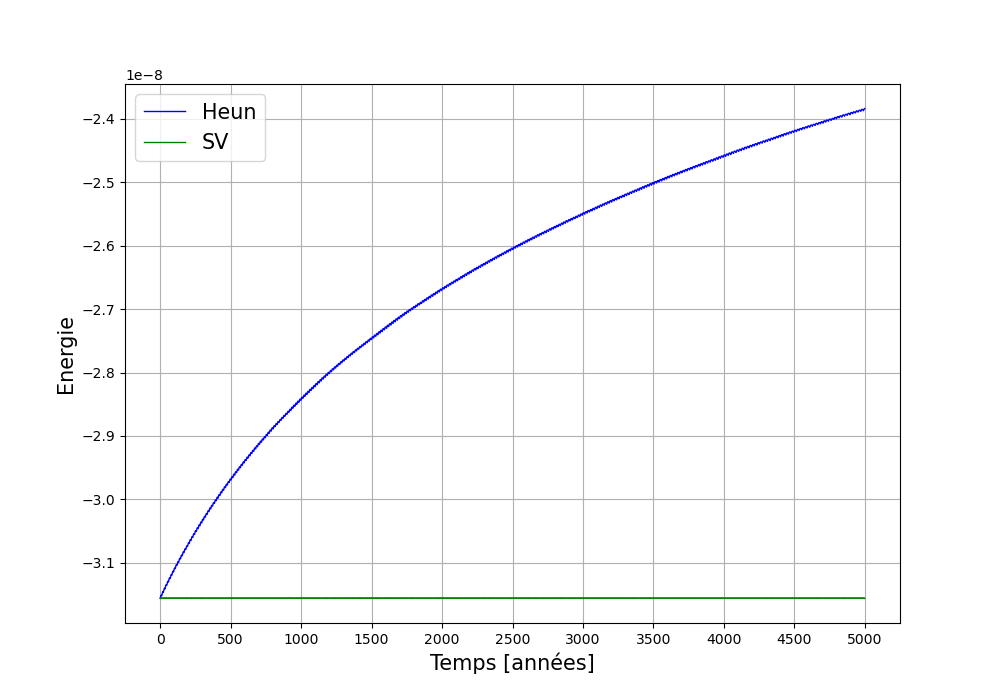

In [168]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1,1,1)
ax.plot(solHeun['t'],solHeun['E'],c='blue',label='Heun',linewidth=1)
ax.plot(solSV['t'],solSV['E'],c='green',label='SV',linewidth=1)

ax.set_xlabel('Temps [années]',fontsize=15)
ax.set_ylabel('Energie',fontsize=15)
ax.set_xscale('linear')
ax.set_xticks(np.linspace(0,tmax,11))
ax.set_xticklabels(np.linspace(0,N_tmax,11,dtype=int))
ax.grid(True)
ax.legend(fontsize=15)
plt.show()

### Plot SV

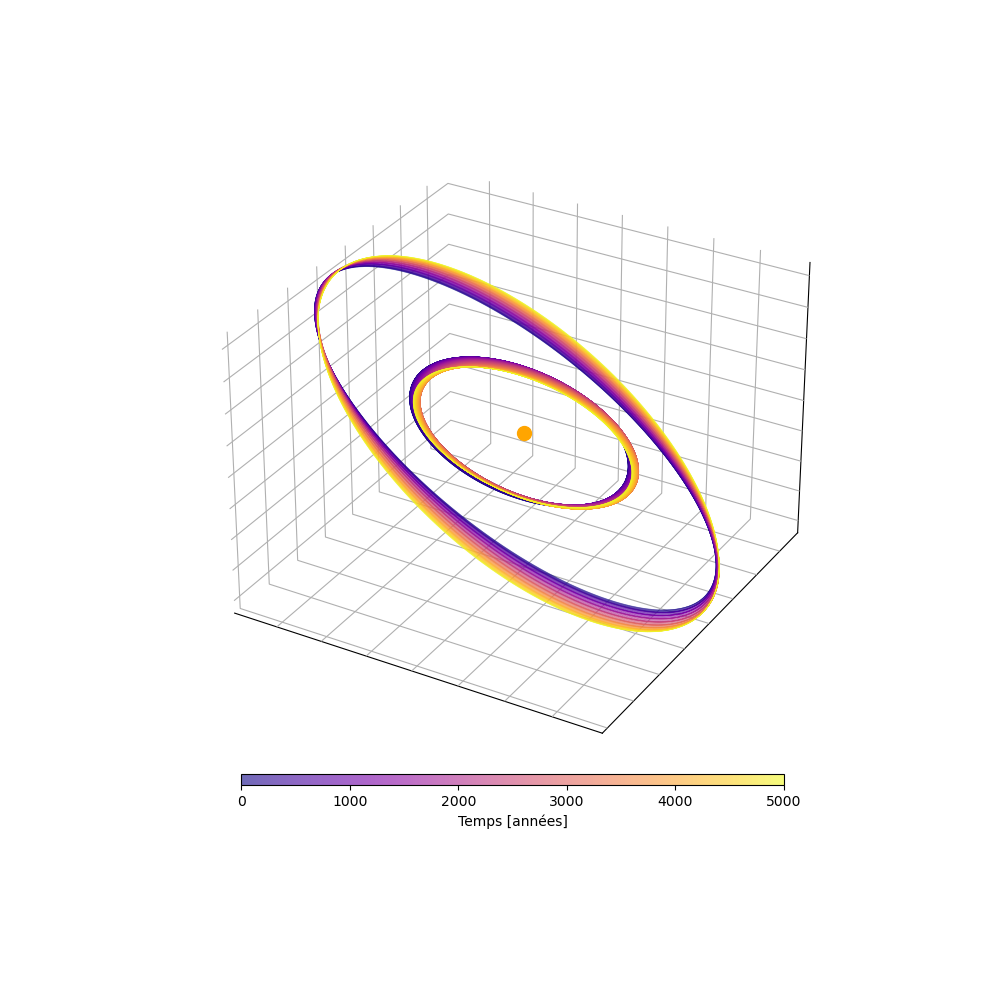

In [169]:
norm = plt.Normalize(solSV['t'].min(),solSV['t'].max()) # Crée la norme pour la colorbar

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1,projection='3d')

# Crée la trajectoire de Jupiter et l'associe à la colorbar
points_J = np.array([solSV['pos'][3,:],solSV['pos'][4,:],solSV['pos'][5,:]]).T.reshape(-1,1,3)
segments_J = np.concatenate([points_J[:-1], points_J[1:]], axis=1)
lc_J = Line3DCollection(segments=segments_J,cmap = 'plasma',norm = norm)
lc_J.set_array(solSV['t'])
lc_J.set_linewidth(0.3)
lc_J.set_alpha(.6)
line_J = ax.add_collection(lc_J)

ax.set_xlim(left=solSV['pos'][3,:].min(),right=solSV['pos'][3,:].max())
ax.set_ylim(bottom=solSV['pos'][4,:].min(),top=solSV['pos'][4,:].max())
ax.set_zlim(bottom=solSV['pos'][5,:].min(),top=solSV['pos'][5,:].max())

if N_body == 3:
    # Crée la trajectoire de Saturen et l'associe à la colorbar
    points_S = np.array([solSV['pos'][6,:],solSV['pos'][7,:],solSV['pos'][8,:]]).T.reshape(-1,1,3)
    segments_S = np.concatenate([points_S[:-1], points_S[1:]], axis=1)
    lc_S = Line3DCollection(segments=segments_S,cmap = 'plasma',norm = norm)
    lc_S.set_array(solHeun['t'])
    lc_S.set_linewidth(0.3)
    lc_S.set_alpha(.6)
    line_S = ax.add_collection(lc_S)

    ax.set_xlim(left=solSV['pos'][6,:].min(),right=solSV['pos'][6,:].max())
    ax.set_ylim(bottom=solSV['pos'][7,:].min(),top=solSV['pos'][7,:].max())
    ax.set_zlim(bottom=solSV['pos'][8,:].min(),top=solSV['pos'][8,:].max())

color = fig.colorbar(line_J,ax=ax,label='Temps [années]',orientation='horizontal',aspect=50,shrink=.7,pad=0)
color.set_ticks(np.linspace(0,5000*365,6))
color.set_ticklabels(np.linspace(0,5000,6,dtype=int))

ax.plot(solSV['pos'][0,:],solSV['pos'][1,:],solSV['pos'][2,:],c='orange')
ax.scatter(solSV['pos'][0,0],solSV['pos'][1,0],solSV['pos'][2,0],c='orange',s=100)

x=1
ax.xaxis.set_pane_color((x,x,x,1))
ax.yaxis.set_pane_color((x,x,x,1))
ax.zaxis.set_pane_color((x,x,x,1))

xticks =  ax.xaxis.get_major_ticks()
for t in xticks:
    t.set_visible(False)
yticks =  ax.yaxis.get_major_ticks()
for t in yticks:
    t.set_visible(False)
zticks =  ax.zaxis.get_major_ticks()
for t in zticks:
    t.set_visible(False)

plt.show()

-3.155507340744949e-08


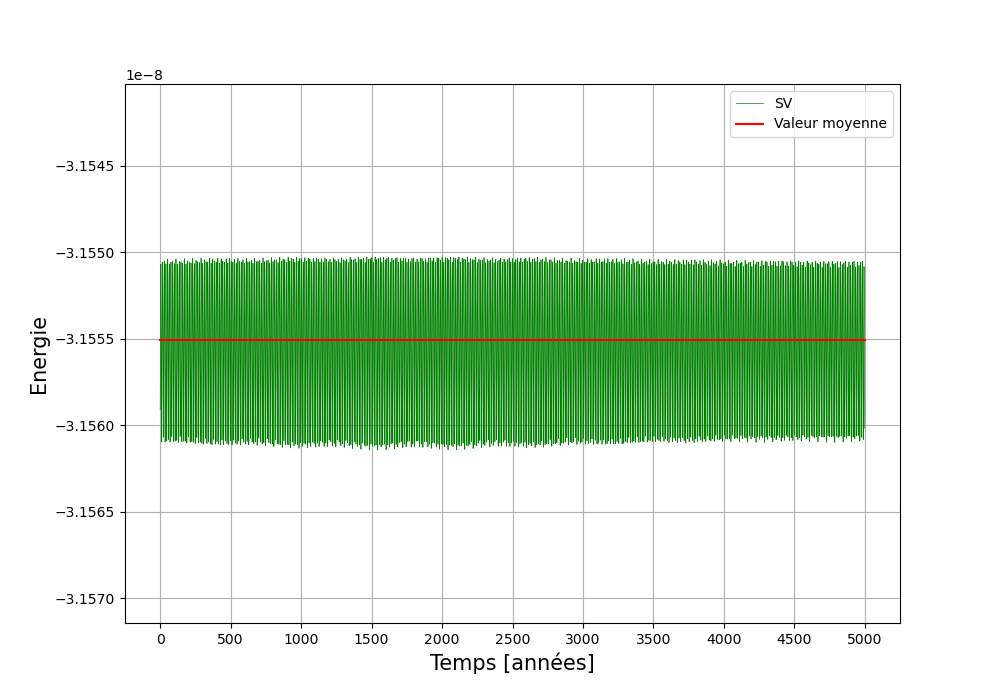

In [173]:
Emean = np.average(solSV['E'])
print(Emean)

fig= plt.figure(figsize=(10,7))
ax = fig.add_subplot(1,1,1)
ax.plot(solSV['t'],solSV['E'],linewidth=.5,c='g',label='SV')
ax.plot([0,solSV['t'][-1]],[Emean,Emean],c='red',label = 'Valeur moyenne')
ax.set_ylim(bottom=solSV['E'].min()-1e-11,top=solSV['E'].max()+1e-11)
ax.set_xlabel('Temps [années]',fontsize=15)
ax.set_ylabel('Energie',fontsize=15)
ax.set_xscale('linear')
ax.set_xticks(np.linspace(0,tmax,11))
ax.set_xticklabels(np.linspace(0,N_tmax,11,dtype=int))
ax.grid(True)
ax.legend()

plt.show()

## Analyse d'erreur

In [92]:
def data_cont(*args):
    M = args[0].size
    N = 0
    for i in range(len(args)):
        N += args[i][0].size
    data = np.zeros((M,N))
    i = 0
    m = 0
    while i < len(args):
        if (args[i][0].size == 1):
            arr = np.array(args[i]).reshape(args[i].shape[0],1)
        else:
            arr = args[i]
        n = m+arr.shape[1]
        data[:,m:n] = arr
        m = n
        i +=1
    return data

def dist_arr(a,b):
    d = np.zeros(a.shape[0])
    for i in range(d.shape[0]):
        d[i] = np.sqrt((a[i,0]-b[i,0])**2 + (a[i,1]-b[i,1])**2 + (a[i,2]-b[i,2])**2)
    return d

def E_array(masses, pos, mom):
    en = np.zeros(pos.shape[1])
    for i in range(en.shape[0]):
        en[i] = energy(pos[:,i],mom[:,i],masses)
    return en

def to_int(a):
    b = np.zeros_like(a)
    for i in range(len(a)):
        b[i] = int(a[i])
    return b

def rad(a):
    return np.sqrt(np.sum(a**2))

### Upload des données et rectifications p/r CM

In [174]:
# Upload data from website
Jup_true = np.loadtxt(fname=".\Data\Jupiter.txt",dtype=float,delimiter=',',skiprows=5,usecols=(2,3,4,5,6,7))
Sat_true = np.loadtxt(fname=".\Data\Saturne.txt",dtype=float,delimiter=',',skiprows=5,usecols=(2,3,4,5,6,7))
Sun_true = np.zeros_like(Jup_true)
data_true = [Sun_true.transpose(),Jup_true.transpose(), Sat_true.transpose()]
pos_true = mom_true = np.zeros((9,Jup_true.shape[0]))
for i in range(3):
    j = i*3
    pos_true[j:j+3] = data_true[i][0:3]
    mom_true[j:j+3] = data_true[i][3:6]

# Rectification par rapport au CM
cm = CM(pos_true,masses)
for i in range(3):
    j = i*3
    pos_true[j:j+3] = pos_true[j:j+3]-cm

### Manipulation data

In [184]:
# Conditions initiales taken 08-15-2024 at 12:00:00
N_body = 3
Sun = np.array([[0.,0.,0.],[0.,0.,0.]])
Jup = str_to_array('2.6612786825339	4.2508243026341	-0.0771991078745	-0.0064893013125	0.0043637460975	0.0001270618987')
Sat = str_to_array('9.2195874869192	-2.9920487806866	-0.3149005362607	0.0014084238297	0.0053001590964	-0.0001482901014')
tmax_anal = 1000*365

In [95]:
# Data production
new_data = input("Créer des nouveaux fichiers ? Y/N\nSi vous êtes pas sûrs, c'est que c'est non.")
if new_data == 'Y':
    new_data = True
else :
    new_data = False
DT = np.geomspace(3,3000,25)
if new_data:
    try:
        for dt in DT:
            solHeun = Heun(N_body, dt, tmax, masses, Sun, Jup, Sat)
            solSV = SV(N_body, dt, tmax, masses, Sun, Jup, Sat)
            print(solHeun['dt'])
            
            pos_Heun = np.transpose(solHeun['pos'])
            data_Heun = data_cont(solHeun['t'],pos_Heun,solHeun['E'])
            pos_SV = np.transpose(solSV['pos'])
            data_SV = data_cont(solHeun['t'],pos_SV,solSV['E'])

            if N_body == 2:
                np.savetxt(fname="./Data/dt/Heun_dt{:.1f}_N{}.txt".format(solHeun['dt'],N_body), X=data_Heun ,delimiter=',',header="N, dt, tmax\n{}, {}, {}\nt, xSun, ySun, zSun, xJup, yJup, zJup, E".format(N_body,solHeun['dt'],tmax))
                np.savetxt(fname="./Data/dt/SV_dt{:.1f}_N{}.txt".format(solSV['dt'],N_body), X=data_SV ,delimiter=',',header="N, dt, tmax\n{}, {}, {}\nt, xSun, ySun, zSun, xJup, yJup, zJup, E".format(N_body,solHeun['dt'],tmax))
            if N_body == 3:
                np.savetxt(fname="./Data/dt/Heun_dt{:.1f}_N{}.txt".format(solHeun['dt'],N_body), X=data_Heun ,delimiter=',',header="N, dt, tmax\n{}, {}, {}\nt, xSun, ySun, zSun, xJup, yJup, zJup, xSat, ySat, zSat E".format(N_body,solHeun['dt'],tmax))
                np.savetxt(fname="./Data/dt/SV_dt{:.1f}_N{}.txt".format(solSV['dt'],N_body), X=data_SV ,delimiter=',',header="N, dt, tmax\n{}, {}, {}\nt, xSun, ySun, zSun, xJup, yJup, zJup, xSat, ySat, zSat E".format(N_body,solHeun['dt'],tmax))
    finally :
        ws.PlaySound('../../Messenger.wav',ws.SND_FILENAME)

In [188]:
# Upload des data
data_H_dt = {}
data_SV_dt = {}
# /!\ Must be the same than the cell above /!\
DT = np.geomspace(3,3000,25)
# /!\ ==================================== /!\
n_t = to_int(np.round(tmax_anal/DT))
DT = tmax/n_t
for dt in DT:
    data_H_dt[dt] = np.loadtxt(fname="./Data/dt/Heun_dt{:.1f}_N{}.txt".format(dt,N_body),dtype=float,delimiter=',',skiprows=3)
    data_SV_dt[dt] = np.loadtxt(fname=".\Data\dt\SV_dt{:.1f}_N{}.txt".format(dt,N_body),dtype=float,delimiter=',',skiprows=3)


### Erreur sur l'énergie

##### Plot de l'énergie finale pour differents timestep

In [190]:
E_H = np.zeros_like(DT)
E_SV = np.zeros_like(DT)
for i in range(DT.shape[0]):
    dt = DT[i]
    E_H[i] = abs((data_H_dt[dt][-1,-1]-data_H_dt[dt][0,-1])/data_H_dt[dt][0,-1])
    E_SV[i] = abs((data_SV_dt[dt][-1,-1]-data_SV_dt[dt][0,-1])/data_SV_dt[dt][0,-1])


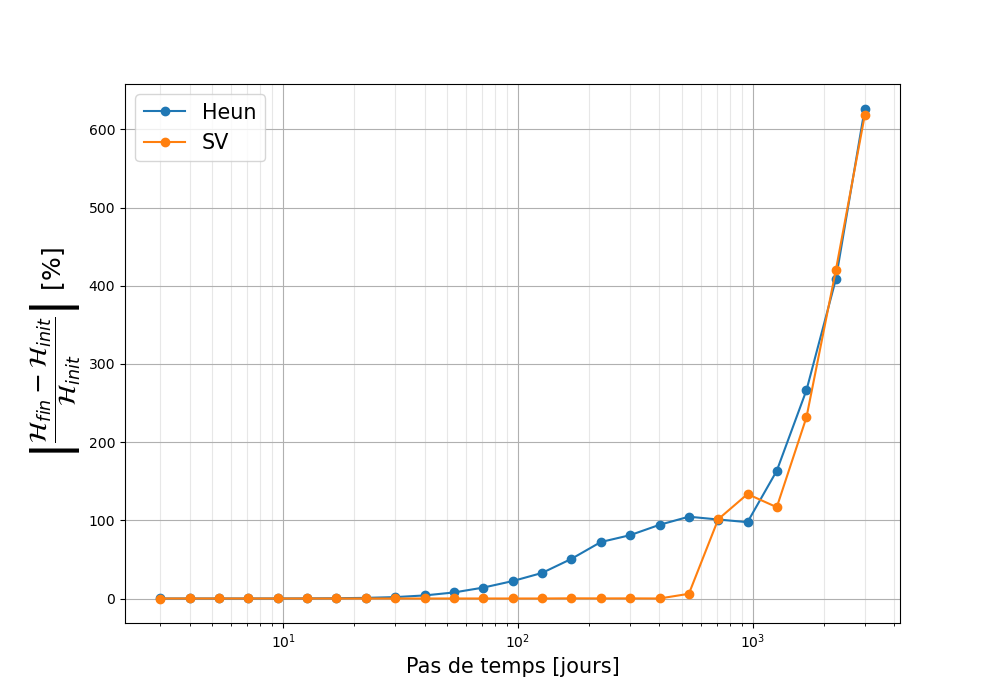

In [192]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1,1,1)
ax.plot(DT,E_H*100,'o-',label='Heun')
ax.plot(DT,E_SV*100,'o-',label='SV')
ax.set_xlabel('Pas de temps [jours]',fontsize=15)
ax.set_ylabel('$\left|\dfrac{\mathcal{H}_{fin}-\mathcal{H}_{init}}{\mathcal{H}_{init}}\\right|$ [%]',fontsize=18)
ax.set_xscale('log')
ax.grid(True,'major')
ax.grid(True,'minor',alpha=.3)
ax.legend(fontsize=15)
plt.show()

### Analyse des trajectoires

In [194]:
idx = [0,8,14]
pos_H_J = []
pos_SV_J = []
for i in idx:
    dt = DT[i]
    pos_H_J.append(data_H_dt[dt][:,4:7])
    pos_SV_J.append(data_H_dt[dt][:,4:7])
idx.reverse()

#### Heun

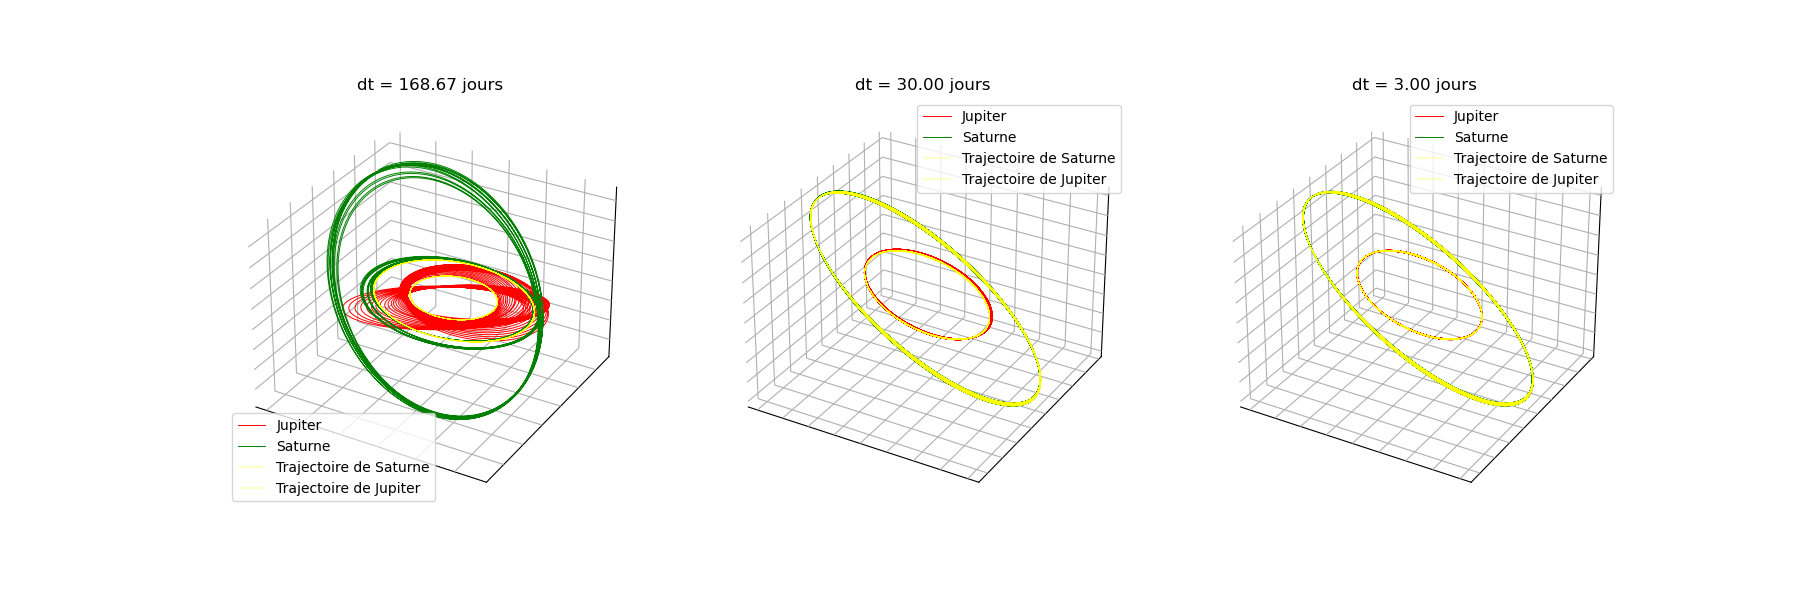

In [195]:
fig= plt.figure(figsize=(18,6))
ax = fig.subplots(1,3,subplot_kw=dict(projection='3d'))
inc = 0
for i in idx :
    dt = DT[i]
    ax[inc].plot(data_H_dt[dt][:,4],data_H_dt[dt][:,5],data_H_dt[dt][:,6],linewidth=.7,label='Jupiter',color='red')
    if N_body == 3:
        ax[inc].plot(data_H_dt[dt][:,7],data_H_dt[dt][:,8],data_H_dt[dt][:,9],linewidth=.7,label='Saturne',color='green')
        ax[inc].plot(Sat_true[:,0],Sat_true[:,1],Sat_true[:,2],linewidth=.3,label='Trajectoire de Saturne',color='yellow')
    ax[inc].plot(Jup_true[:,0],Jup_true[:,1],Jup_true[:,2],linewidth=.3,label='Trajectoire de Jupiter',color='yellow')
    ax[inc].set_title('dt = {:.2f} jours'.format(dt))
    ax[inc].legend()
    x = 1
    ax[inc].xaxis.set_pane_color((x,x,x,1))
    ax[inc].yaxis.set_pane_color((x,x,x,1))
    ax[inc].zaxis.set_pane_color((x,x,x,1))
    ax[inc].grid(color=(1-x,1-x,1-x,1))
    xticks =  ax[inc].xaxis.get_major_ticks()
    for t in xticks:
        t.set_visible(False)
        t.set_visible(False)
    yticks =  ax[inc].yaxis.get_major_ticks()
    for t in yticks:
        t.set_visible(False)
        t.set_visible(False)
    zticks =  ax[inc].zaxis.get_major_ticks()
    for t in zticks:
        t.set_visible(False)
        t.set_visible(False)

    inc+=1

plt.show()

168.6691312384473


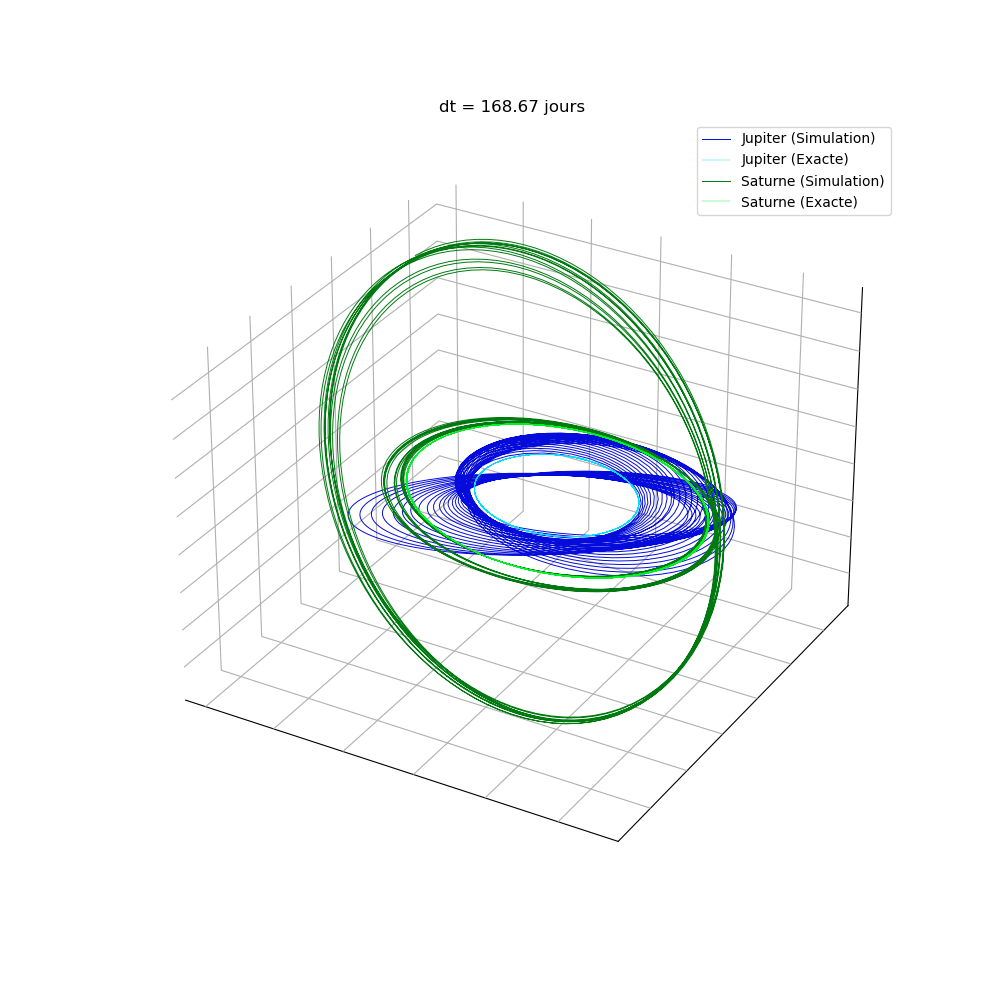

In [196]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1,projection='3d')
dt = DT[14]
print(dt)
ax.plot(data_H_dt[dt][:,4],data_H_dt[dt][:,5],data_H_dt[dt][:,6],linewidth=.7,label='Jupiter (Simulation)',color='#040BDA')
ax.plot(Jup_true[:,0],Jup_true[:,1],Jup_true[:,2],linewidth=.3,label='Jupiter (Exacte)',color='#00DEFF')
ax.plot(data_H_dt[dt][:,7],data_H_dt[dt][:,8],data_H_dt[dt][:,9],linewidth=.7,label='Saturne (Simulation)',color='#007910')
ax.plot(Sat_true[:,0],Sat_true[:,1],Sat_true[:,2],linewidth=.3,label='Saturne (Exacte)',color='#00F028')

ax.legend()
ax.set_title('dt = {:.2f} jours'.format(dt))
ax.legend()
x = 1
ax.xaxis.set_pane_color((x,x,x,1))
ax.yaxis.set_pane_color((x,x,x,1))
ax.zaxis.set_pane_color((x,x,x,1))
ax.grid(color=(1-x,1-x,1-x,1))
xticks =  ax.xaxis.get_major_ticks()
for t in xticks:
    t.set_visible(False)
    t.set_visible(False)
yticks =  ax.yaxis.get_major_ticks()
for t in yticks:
    t.set_visible(False)
    t.set_visible(False)
zticks =  ax.zaxis.get_major_ticks()
for t in zticks:
    t.set_visible(False)
    t.set_visible(False)
plt.show()

168.6691312384473


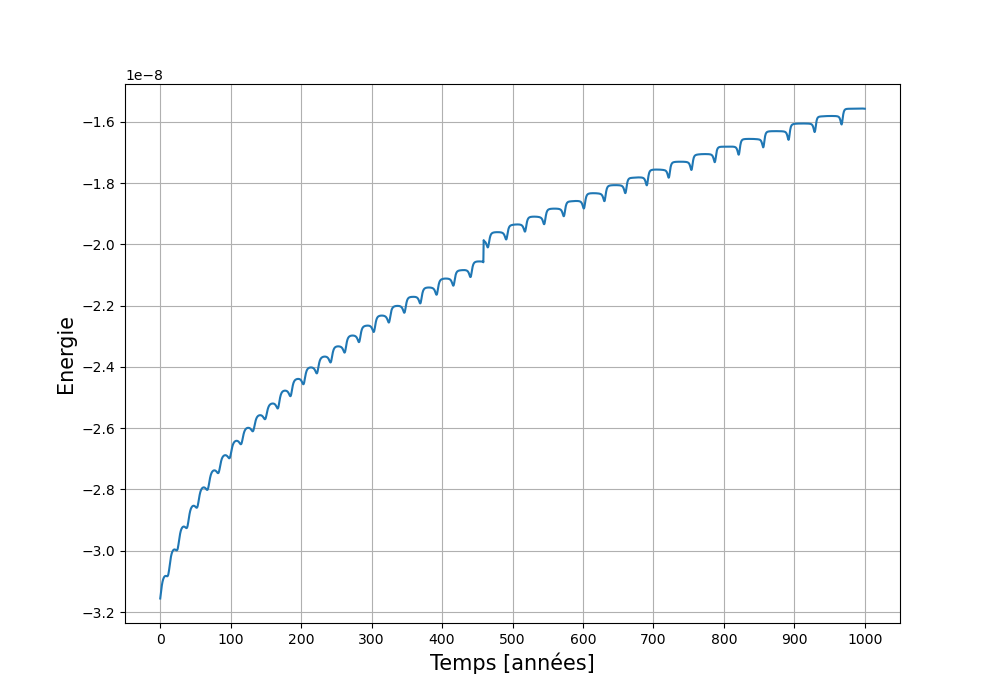

In [197]:
fig = plt.figure(figsize=(10,7))
dt = DT[14]
print(dt)
ax = fig.add_subplot(1,1,1)
ax.plot(data_H_dt[dt][:,0],data_H_dt[dt][:,-1])
ax.set_xlabel('Temps [années]',fontsize=15)
ax.set_ylabel('Energie',fontsize=15)
ax.set_xscale('linear')
ax.set_xticks(np.linspace(0,tmax,11))
ax.set_xticklabels(np.linspace(0,1000,11,dtype=int))
ax.grid(True)
# ax.legend(fontsize=15)
plt.show()

#### SV

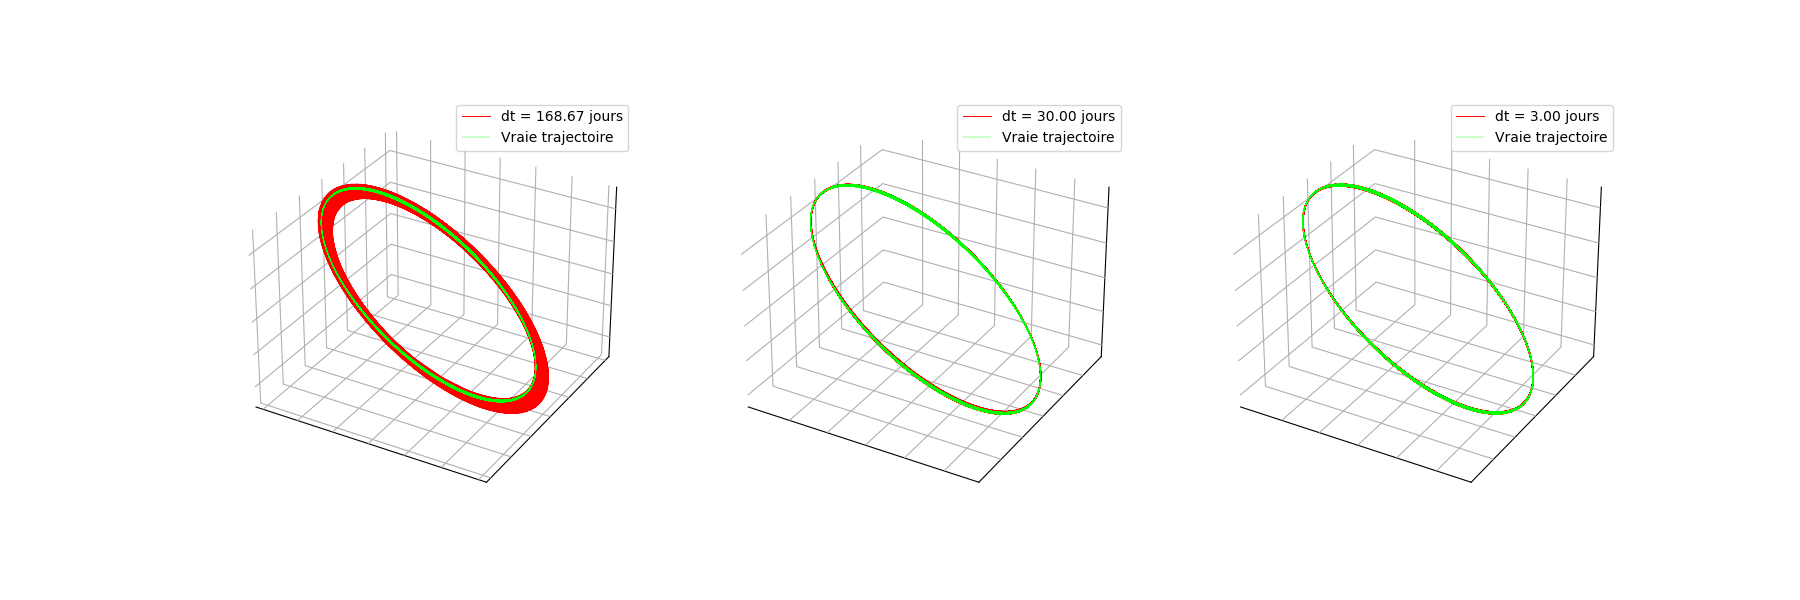

In [198]:
fig= plt.figure(figsize=(18,6))
ax = fig.subplots(1,3,subplot_kw=dict(projection='3d'))
inc = 0
for i in idx :
    dt = DT[i]
    ax[inc].plot(data_SV_dt[dt][:,4],data_SV_dt[dt][:,5],data_SV_dt[dt][:,6],linewidth=.7,label='dt = {:.2f} jours'.format(dt),color='red')
    ax[inc].plot(Jup_true[:,0],Jup_true[:,1],Jup_true[:,2],linewidth=.3,label='Vraie trajectoire',color='lime')
    ax[inc].legend()
    x = 1
    ax[inc].xaxis.set_pane_color((x,x,x,1))
    ax[inc].yaxis.set_pane_color((x,x,x,1))
    ax[inc].zaxis.set_pane_color((x,x,x,1))
    ax[inc].grid(color=(1-x,1-x,1-x,1))
    xticks =  ax[inc].xaxis.get_major_ticks()
    for t in xticks:
        t.set_visible(False)
        t.set_visible(False)
    yticks =  ax[inc].yaxis.get_major_ticks()
    for t in yticks:
        t.set_visible(False)
        t.set_visible(False)
    zticks =  ax[inc].zaxis.get_major_ticks()
    for t in zticks:
        t.set_visible(False)
        t.set_visible(False)

    inc+=1

plt.show()

2.999991780844436


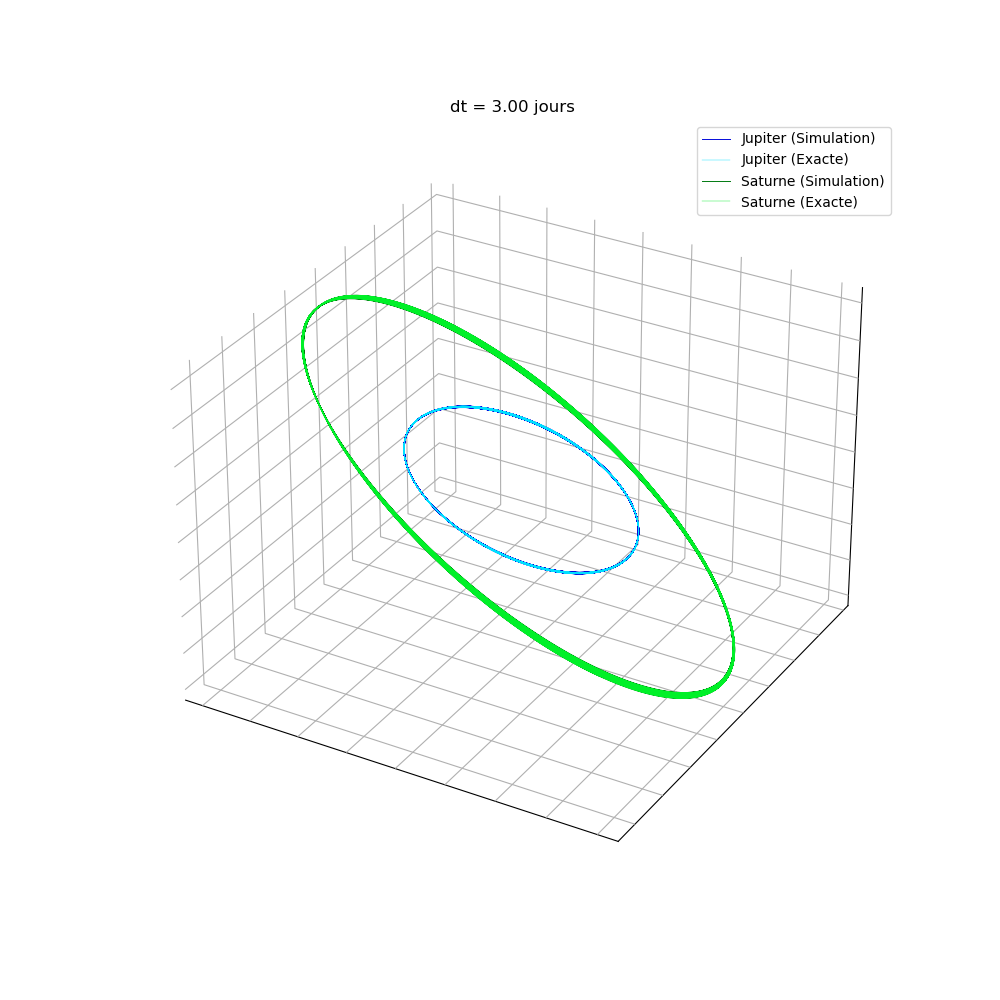

In [199]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1,projection='3d')
dt = DT[0]
print(dt)
ax.plot(data_SV_dt[dt][:,4],data_SV_dt[dt][:,5],data_SV_dt[dt][:,6],linewidth=.7,label='Jupiter (Simulation)',color='#040BDA')
ax.plot(Jup_true[:,0],Jup_true[:,1],Jup_true[:,2],linewidth=.3,label='Jupiter (Exacte)',color='#00DEFF')
ax.plot(data_SV_dt[dt][:,7],data_SV_dt[dt][:,8],data_SV_dt[dt][:,9],linewidth=.7,label='Saturne (Simulation)',color='#007910')
ax.plot(Sat_true[:,0],Sat_true[:,1],Sat_true[:,2],linewidth=.3,label='Saturne (Exacte)',color='#00F028')

ax.legend()
ax.set_title('dt = {:.2f} jours'.format(dt))
ax.legend()
x = 1
ax.xaxis.set_pane_color((x,x,x,1))
ax.yaxis.set_pane_color((x,x,x,1))
ax.zaxis.set_pane_color((x,x,x,1))
ax.grid(color=(1-x,1-x,1-x,1))
xticks =  ax.xaxis.get_major_ticks()
for t in xticks:
    t.set_visible(False)
    t.set_visible(False)
yticks =  ax.yaxis.get_major_ticks()
for t in yticks:
    t.set_visible(False)
    t.set_visible(False)
zticks =  ax.zaxis.get_major_ticks()
for t in zticks:
    t.set_visible(False)
    t.set_visible(False)
plt.show()